In [2]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from sqlalchemy import create_engine
import pandas as pd
import datetime

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin


# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim

# for number-crunching
import numpy as np

import copy

In [3]:
user = "erpnext_sql"
password = "rtp[ps4XRF0_pX"
db = "_abde597b15b69fc8"
host = "erpnext.responsible-ai.net"
port = "3333"

In [4]:
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}")

# Data

In [5]:
data_sql_full = pd.read_sql("""
    Select 		
	po.name, 
        po.supplier, 
        po.total_qty,
        po.transaction_date as order_date,
        po_items.schedule_date,
        po_receipt.posting_date as delivered_date
    FROM `tabPurchase Order` po
    LEFT JOIN `tabPurchase Order Item` po_items
    	on po.name = po_items.parent
    LEFT JOIN `tabPurchase Receipt Item` po_receipt_item
    	on po.name = po_receipt_item.purchase_order 
    LEFT JOIN `tabPurchase Receipt` po_receipt
    	on po_receipt_item.parent = po_receipt.name
    """, engine)

In [6]:
data_sql_full.head()

,name,supplier,total_qty,order_date,schedule_date,delivered_date
0,e,Beans Inc.,750.0,2020-06-14,None,None
1,PUR-ORD-2024-08-00002,Beans Inc.,750.0,2023-04-24,2023-04-29,2023-05-04
2,PUR-ORD-2024-08-00003,Fair Trade AG,750.0,2024-09-08,2024-09-21,None
3,PUR-ORD-2024-08-00004,Aromatico,1000.0,2022-10-26,2022-11-10,2022-11-29
4,PUR-ORD-2024-08-00005,Aromatico,500.0,2022-03-18,2022-04-05,2022-04-24


In [7]:
# Get size of dataset
data_sql_full.shape

(17181, 6)

In [8]:
# Check datatypes
data_sql_full.dtypes

name               object
supplier           object
total_qty         float64
order_date         object
schedule_date      object
delivered_date     object
dtype: object

In [9]:
# Drop nulls
data_sql_full.dropna(inplace=True, subset=["delivered_date", "schedule_date"])

In [10]:
# Convert timestamps
data_sql_full["delivered_date"] = pd.to_datetime(data_sql_full["delivered_date"])
data_sql_full["schedule_date"] = pd.to_datetime(data_sql_full["schedule_date"])

In [11]:
# Calculate if purchase order was late
data_sql_full["late"] = data_sql_full["delivered_date"] > data_sql_full["schedule_date"]

In [13]:
# calculate days late
data_sql_full["days_late"] = (data_sql_full["delivered_date"] - data_sql_full["schedule_date"]).dt.days

In [14]:
# get average number of days late
data_sql_full["days_late"].mean()

10.407321772639692

In [15]:
# Check days late by supplier
data_sql_full.groupby('supplier')["days_late"].mean().sort_values(ascending=False)

supplier
Aromatico                16.612748
Fair Trade AG            13.355965
Beans Inc.                9.301186
Handelskontor Hamburg     6.421256
Farmers of Brazil         6.359859
Name: days_late, dtype: float64

In [16]:
# Create Dummies for Supplier
d_suppliers = pd.get_dummies(data_sql_full['supplier'], prefix="d")

In [17]:
# Add dummies to dataset
data_for_model = pd.concat([data_sql_full, d_suppliers], axis=1)

In [18]:
# Create feature list
features = ["total_qty"] + list(d_suppliers.columns)

In [19]:
features

['total_qty',
 'd_Aromatico',
 'd_Beans Inc.',
 'd_Fair Trade AG',
 'd_Farmers of Brazil',
 'd_Handelskontor Hamburg']

In [20]:
data_for_model

,name,supplier,total_qty,order_date,schedule_date,delivered_date,late,days_late,d_Aromatico,d_Beans Inc.,d_Fair Trade AG,d_Farmers of Brazil,d_Handelskontor Hamburg
1,PUR-ORD-2024-08-00002,Beans Inc.,750.0,2023-04-24,2023-04-29,2023-05-04,True,5,False,True,False,False,False
3,PUR-ORD-2024-08-00004,Aromatico,1000.0,2022-10-26,2022-11-10,2022-11-29,True,19,True,False,False,False,False
4,PUR-ORD-2024-08-00005,Aromatico,500.0,2022-03-18,2022-04-05,2022-04-24,True,19,True,False,False,False,False
5,PUR-ORD-2024-08-00006,Farmers of Brazil,100.0,2023-12-01,2023-12-15,2023-12-23,True,8,False,False,False,True,False
6,PUR-ORD-2024-08-00007,Farmers of Brazil,750.0,2024-05-17,2024-05-29,2024-05-29,False,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17175,PUR-ORD-2024-08-17176,Handelskontor Hamburg,2000.0,2023-05-18,2023-05-26,2023-06-01,True,6,False,False,False,False,True
17176,PUR-ORD-2024-08-17177,Fair Trade AG,1500.0,2023-11-17,2023-12-16,2024-01-04,True,19,False,False,True,False,False
17177,PUR-ORD-2024-08-17178,Handelskontor Hamburg,2000.0,2022-05-03,2022-05-26,2022-06-14,True,19,False,False,False,False,True
17178,PUR-ORD-2024-08-17179,Aromatico,100.0,2021-02-10,2021-03-02,2021-03-17,True,15,True,False,False,False,False


# Re-organize the data: train/test in DataLoaders

In [23]:
# Define Train and Test datasets based on order_date
split_date = datetime.date(2022, 9, 1)
train = data_for_model[data_for_model["order_date"] <= split_date]
test = data_for_model[data_for_model["order_date"] > split_date]

# Features to keep
features = ['total_qty', 'd_Aromatico', 'd_Beans Inc.', 'd_Fair Trade AG', 'd_Farmers of Brazil', 'd_Handelskontor Hamburg']

# Convert boolean columns to integers
train[features] = train[features].astype(float)
test[features] = test[features].astype(float)

# Ensure all data is numeric and handle missing values
train[features] = train[features].apply(pd.to_numeric, errors='coerce')
train['days_late'] = pd.to_numeric(train['days_late'], errors='coerce')
test[features] = test[features].apply(pd.to_numeric, errors='coerce')
test['days_late'] = pd.to_numeric(test['days_late'], errors='coerce')

# Drop rows with NaNs
train = train.dropna()
test = test.dropna()

# Extract DataFrame to TRAIN tensors
train_dataT = torch.tensor(train[features].values).float()
train_labelT = torch.tensor(train['days_late'].values).float().view(-1, 1)  # The 'view(-1, 1)' is to transform to matrix

# Extract DataFrame to TEST tensors
test_dataT = torch.tensor(test[features].values).float()
test_labelT = torch.tensor(test['days_late'].values).float().view(-1, 1)  # The 'view(-1, 1)' is to transform to matrix

# Confirm sizes
print(f'Original data: {data_for_model.shape}\n')
print(f'   Train data: {train_dataT.shape}\n')
print(f' Train labels: {train_labelT.shape}\n')
print(f'    Test data: {test_dataT.shape}\n')
print(f'  Test labels: {test_labelT.shape}')

Original data: (15570, 13)

   Train data: torch.Size([9195, 6])

 Train labels: torch.Size([9195, 1])

    Test data: torch.Size([6375, 6])

  Test labels: torch.Size([6375, 1])


/var/folders/96/gw_qp3_x47d41c8ywgkgqx9c0000gn/T/ipykernel_52057/3484448776.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = train[features].astype(float)
/var/folders/96/gw_qp3_x47d41c8ywgkgqx9c0000gn/T/ipykernel_52057/3484448776.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = test[features].astype(float)
/var/folders/96/gw_qp3_x47d41c8ywgkgqx9c0000gn/T/ipykernel_52057/3484448776.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [24]:
# then convert them into PyTorch Dataset
train_data = torch.utils.data.TensorDataset(train_dataT, train_labelT)

# finally, translate into dataloader objects
batchsize  = 32
train_data = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)


# Standard model

In [26]:

# Define the neural network architecture
class ANNDaysLate(nn.Module):
    def __init__(self):
        super(ANNDaysLate, self).__init__()
        
        # Input layer
        self.input = nn.Linear(6, 64)
        
        # Hidden layers
        self.hidden1 = nn.Linear(64, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.hidden4 = nn.Linear(64, 32)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)
        
        # Output layer
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout1(x)
        x = F.relu(self.hidden1(x))
        x = self.dropout2(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout3(x)
        x = F.relu(self.hidden3(x))
        x = self.dropout4(x)
        x = F.relu(self.hidden4(x))
        x = self.output(x)  # No activation function for the output layer
        return x
      
# Instantiate the model
model = ANNDaysLate()
print(model)

ANNDaysLate(
  (input): Linear(in_features=6, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (hidden4): Linear(in_features=64, out_features=32, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [31]:
# Instantiate the model
model = ANNDaysLate()

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 2000
trainLoss = []
testLoss = []

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(train_dataT)
    loss = loss_function(outputs, train_labelT)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track the training loss
    trainLoss.append(loss.item())
    
    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_dataT)
        test_loss = loss_function(test_outputs, test_labelT)
        testLoss.append(test_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [10/2000], Train Loss: 85.6591, Test Loss: 83.3412
Epoch [20/2000], Train Loss: 83.4150, Test Loss: 84.0204
Epoch [30/2000], Train Loss: 83.1213, Test Loss: 85.1631
Epoch [40/2000], Train Loss: 82.4421, Test Loss: 84.2129
Epoch [50/2000], Train Loss: 81.6872, Test Loss: 84.9441
Epoch [60/2000], Train Loss: 81.6436, Test Loss: 84.2065
Epoch [70/2000], Train Loss: 81.5305, Test Loss: 85.1209
Epoch [80/2000], Train Loss: 80.9960, Test Loss: 84.6622
Epoch [90/2000], Train Loss: 80.5193, Test Loss: 83.9806
Epoch [100/2000], Train Loss: 80.7848, Test Loss: 83.7414
Epoch [110/2000], Train Loss: 80.4120, Test Loss: 83.9087
Epoch [120/2000], Train Loss: 80.3885, Test Loss: 84.6728
Epoch [130/2000], Train Loss: 79.9420, Test Loss: 85.6093
Epoch [140/2000], Train Loss: 79.6257, Test Loss: 84.7632
Epoch [150/2000], Train Loss: 79.3556, Test Loss: 84.5918
Epoch [160/2000], Train Loss: 78.9120, Test Loss: 84.2221
Epoch [170/2000], Train Loss: 78.6776, Test Loss: 83.6210
Epoch [180/2000], Train

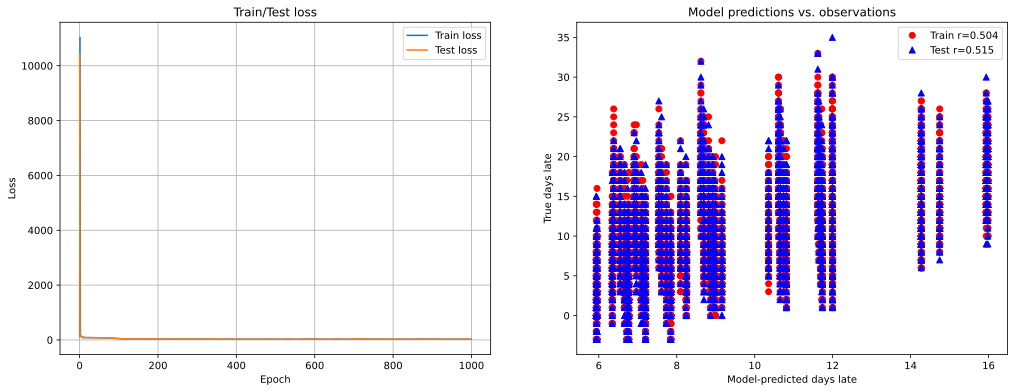

In [28]:
# Evaluate the model on the train and test sets
model.eval()
with torch.no_grad():
    yHatTrain = model(train_dataT)
    yHatTest = model(test_dataT)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(17, 6))

# Plot train/test loss
ax[0].plot(trainLoss, label='Train loss')
ax[0].plot(testLoss, label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

# Plot model predictions vs. observations
ax[1].plot(yHatTrain.detach(), train_labelT, 'ro', label='Train')
ax[1].plot(yHatTest.detach(), test_labelT, 'b^', label='Test')
ax[1].set_xlabel('Model-predicted days late')
ax[1].set_ylabel('True days late')
ax[1].set_title('Model predictions vs. observations')

# Correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().numpy().T, train_labelT.numpy().T)[1, 0]
corrTest = np.corrcoef(yHatTest.detach().numpy().T, test_labelT.numpy().T)[1, 0]
ax[1].legend([f'Train r={corrTrain:.3f}', f'Test r={corrTest:.3f}'])

plt.show()

# Grid CV Model

In [101]:
# Define the neural network architecture
class ANNDaysLate(nn.Module):
    def __init__(self, input_size=6, hidden_sizes=[64, 128, 64, 32], dropout_rate=0.3):
        super(ANNDaysLate, self).__init__()
        
        # Input layer
        self.input = nn.Linear(input_size, hidden_sizes[0])
        
        # Hidden layers
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.hidden2 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.hidden3 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_sizes[3], 1)
    
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout1(x)
        x = F.relu(self.hidden1(x))
        x = self.dropout2(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout3(x)
        x = F.relu(self.hidden3(x))
        x = self.output(x)  # No activation function for the output layer
        return x

In [114]:
# Define a class to wrap the PyTorch model for use with scikit-learn
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size=6, hidden_sizes=[64, 128, 64, 32], dropout_rate=0.3, lr=0.001, num_epochs=100):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.num_epochs = num_epochs
        self.model = ANNDaysLate(input_size, hidden_sizes, dropout_rate)
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    
    def fit(self, X, y):
        X_tensor = torch.tensor(X).float()
        y_tensor = torch.tensor(y).float().view(-1, 1)
        
        for epoch in range(self.num_epochs):
            self.model.train()
            outputs = self.model(X_tensor)
            loss = self.loss_function(outputs, y_tensor)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X).float()
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy()

# Define the hyperparameter grid
param_grid = {
    'hidden_sizes': [[64, 128], [128, 256, 128], [256, 512, 256]],
    'dropout_rate': [0.1, 0.3, 0.5],
    'lr': [0.0001, 0.001, 0.01],
    'num_epochs': [100, 500, 1000]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=PyTorchRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(train_dataT.numpy(), train_labelT.numpy())

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(test_dataT.numpy())

# Evaluate the model on the test set
test_loss = np.mean((test_predictions - test_labelT.numpy())**2)
print(f'Test Loss: {test_loss:.4f}')

Best parameters found:  {'dropout_rate': 0.1, 'hidden_sizes': [64, 128], 'lr': 0.01, 'num_epochs': 1000}
Best score:  -21.041554133097332
Test Loss: 20.2725


In [33]:
# Download best model
import joblib

# Save the best model to a .pkl file
joblib.dump(model, 'newbest_model.pkl')
print("Model saved as 'best_model.pkl'")


Model saved as 'best_model.pkl'


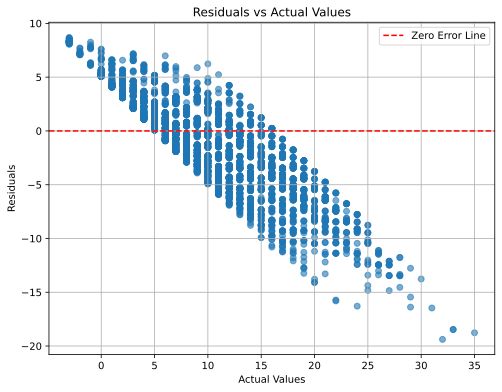

In [115]:
# Calculate residuals
residuals = test_predictions - test_labelT.numpy()

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(test_labelT.numpy(), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label="Zero Error Line")
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()


In [116]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R2
mse = mean_squared_error(test_labelT.numpy(), test_predictions)
r2 = r2_score(test_labelT.numpy(), test_predictions)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R²): {r2:.4f}')

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test_labelT.numpy(), test_predictions))
rmse



Mean Squared Error (MSE): 20.2725
R-squared (R²): 0.4463


4.5025034

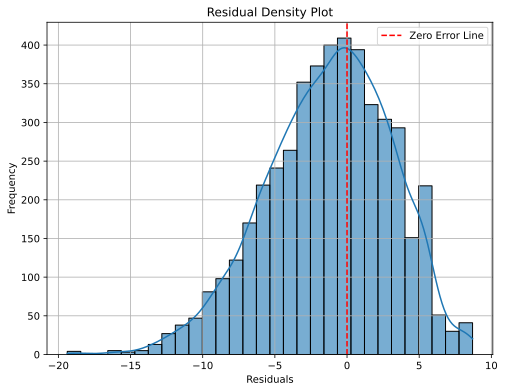

In [117]:
import seaborn as sns

# Plot density of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--', label="Zero Error Line")
plt.title('Residual Density Plot')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()
